In [15]:
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook as tqdm

import sys
sys.path.append('../')
from utils import show_single_frame, show_multiply_frames, get_frames, draw_rois, save_video

### MeanShift & CamShift itself

In [84]:
def meanshift(frames, roi):
    
    # initialize list for rois
    rois = [roi]
    
    # rearrange roi for opencv mean shift
    roi = (roi[0][0], roi[0][1], roi[1][0] - roi[0][0], roi[1][1] - roi[0][1])
    
    # define parameters
    term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )
    hsv_min = np.array([0., 0., 0.])
    hsv_max = np.array([255., 255., 255.])
    
    # get hist for initial roi
    frame = frames[0]
    roi_rgb = frame[roi[1]:roi[1] + roi[3], roi[0]:roi[0] + roi[2]]
    
    cv2.normalize(roi_rgb,  roi_rgb, 0, 255, cv2.NORM_MINMAX)
    
    roi_hsv = cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(roi_hsv, hsv_min, hsv_max)
    roi_hist = cv2.calcHist([roi_hsv], [0], mask, [180], [0, 180])
    cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

    for frame in tqdm(frames[1:]):
        frame_hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
        
        cv2.normalize(frame_hsv, frame_hsv, 0, 255, cv2.NORM_MINMAX)
        
        result = cv2.calcBackProject([frame_hsv], [0], roi_hist, [0, 180], 1)
        _, roi = cv2.meanShift(result, roi, term_crit)
        rois.append(((roi[0], roi[1]), (roi[0] + roi[2], roi[1] + roi[3])))
    
    return rois


def camshift(frames, roi):
    
    # initialize list for rois
    rois = [roi]
    
    # rearrange roi for opencv mean shift
    roi = (roi[0][0], roi[0][1], roi[1][0] - roi[0][0], roi[1][1] - roi[0][1])
    
    # define parameters
    term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )
    hsv_min = np.array([0., 0., 0.])
    hsv_max = np.array([255., 255., 255.])
    
    # get hist
    frame = frames[0]
    roi_rgb = frame[roi[1]:roi[1] + roi[3], roi[0]:roi[0] + roi[2]]
    
    cv2.normalize(roi_rgb,  roi_rgb, 0, 255, cv2.NORM_MINMAX)
    
    roi_hsv = cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(roi_hsv, hsv_min, hsv_max)
    roi_hist = cv2.calcHist([roi_hsv], [0], mask, [180], [0, 180])
    cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

    for frame in tqdm(frames[1:]):
        frame_hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
        
        cv2.normalize(frame_hsv, frame_hsv, 0, 255, cv2.NORM_MINMAX)
        
        result = cv2.calcBackProject([frame_hsv], [0], roi_hist, [0, 180], 1)
        ret, roi = cv2.CamShift(result, roi, term_crit)
        rois.append(((roi[0], roi[1]), (roi[0] + roi[2], roi[1] + roi[3])))
    
    return rois

### Get data

**Define paths to 3 datasets**

In [85]:
dataset_name = 'biker'

if dataset_name == 'biker':
    data = '../data/tracking/biker/img'
elif dataset_name == 'basketball':
    data = '../data/tracking/basketball/img'
elif dataset_name == 'bolt':
    data = '../data/tracking/bolt/img'
else:
    raise Exception('Please choose one of the three possible datasets')

**Get data for one of those datasets**

In [86]:
frames, gray_frames = get_frames(data)

**Take frames where object is trackable**

In [87]:
if dataset_name == 'basketball':
    frames = frames[77:270]
    gray_frames = gray_frames[77:270]
if dataset_name == 'bolt':
    frames = frames[:220]
    gray_frames = gray_frames[:220]

**Show sequence of frames**

In [88]:
show_multiply_frames(frames)

interactive(children=(IntSlider(value=0, description='frame_num', max=141), Output()), _dom_classes=('widget-i…

### Preparation for tracking

**Define initial ROI**

In [89]:
if dataset_name == 'biker':
    roi = ((235, 90), (300, 260))
elif dataset_name == 'basketball':
    roi = ((300, 200), (360, 310))
elif dataset_name == 'bolt':
    roi = ((330, 160), (370, 230))

**Show first frame with bounding box**

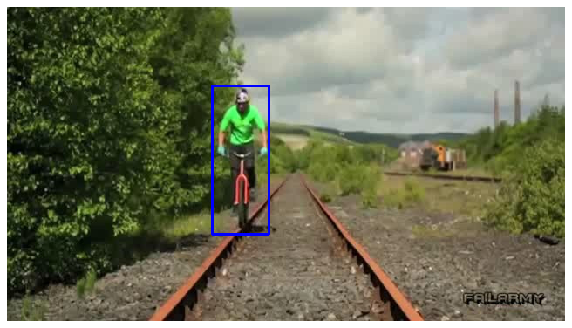

In [90]:
show_single_frame(cv2.rectangle(frames[0].copy(), roi[0], roi[1], (0, 0, 255), 2))

### Perform meanshift tracking

In [91]:
rois = meanshift(frames, roi)

In [92]:
frames_with_rois = draw_rois(frames, rois)
show_multiply_frames(frames_with_rois)

interactive(children=(IntSlider(value=0, description='frame_num', max=141), Output()), _dom_classes=('widget-i…

### Perform camshift tracking

In [93]:
rois = camshift(frames, roi)

In [94]:
frames_with_rois = draw_rois(frames, points)
show_multiply_frames(frames_with_rois)

interactive(children=(IntSlider(value=0, description='frame_num', max=141), Output()), _dom_classes=('widget-i…